Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть
разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что
вам помогло в улучшения работы нейронной сети

Буду работать с датасетом Caravana Cars и попробую обучить нейронную сеть U-net на предобученной модели на ResNet50

### Загрузка библиотек:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import keras

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation, Concatenate
from keras import backend as K

In [2]:
# загрузка и распаковка данных
!unzip -oq /kaggle/input/carvana-image-masking-challenge/train.zip
!unzip -oq /kaggle/input/carvana-image-masking-challenge/train_masks.zip
!unzip -oq /kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip

In [3]:
df = pd.read_csv('./train_masks.csv')
df.shape

(5088, 2)

In [4]:
#разделение датасета на трейн и валидацию

val_size = 0.2
val_split = int(val_size * df.shape[0])

train_df = df[:-val_split]
val_df = df[-val_split:]

train_df.shape, val_df.shape

((4071, 2), (1017, 2))

In [5]:
train_df.head(3)

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...


In [6]:
val_df.head(3)

,img,rle_mask
4071,cf5add31c130_08.jpg,929293 13 931176 79 933066 133 934962 185 9368...
4072,cf5add31c130_09.jpg,929238 59 931120 118 933005 169 934896 214 936...
4073,cf5add31c130_10.jpg,927262 1 929124 115 931014 168 932912 209 9348...


In [7]:
# функция для декодирования rle-строки

def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

In [8]:
img_name, mask_rle = train_df.iloc[0]

img = cv2.imread(f'./train/{img_name}')
mask = rle_decode(mask_rle)

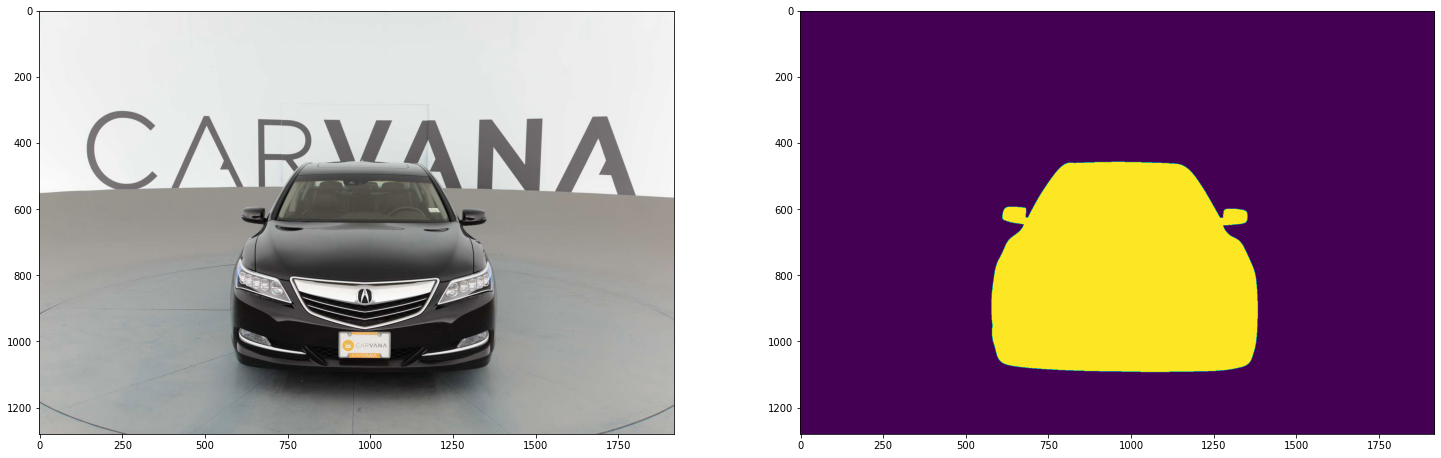

In [9]:
# картинка и соответствующая ей маска
fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(img)
ax[1].imshow(mask)

plt.show()

In [10]:
# создадим функцию по предобработке изображений и масок и приведению их к размеру 256*256, а также батчи для обучения модели
def keras_generator(df, batch_size, preprocess_input=None):
    while True:
        X_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = df.sample(1).values[0]
            img = cv2.imread(f'./train/{img_name}')
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            X_batch += [img]
            y_batch += [mask]

        if preprocess_input:
            X_batch = preprocess_input(np.array(X_batch))
        else:
            X_batch = np.array(X_batch) / 255.0
            
        y_batch = np.array(y_batch, dtype='float')

        yield X_batch, y_batch

In [11]:
for X, y in keras_generator(val_df, batch_size=32):
    print(X.shape, y.shape)
    break

(32, 256, 256, 3) (32, 256, 256)


### Создание модели

In [12]:
# базовая модель ResNet50 без последних слоев

base_model = ResNet50(weights='imagenet', input_shape=(256, 256, 3), include_top=False)
 
base_out = base_model.output
base_out

2022-11-24 09:47:05.482124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 09:47:05.598198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 09:47:05.598938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 09:47:05.600236: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 3s 0us/step


<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [13]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
#  выбираем слои для проброса в U-Net (выбираем те, что идут после функции активации)

conv1 = base_model.get_layer('conv1_relu').output  # (128, 128, 64)
conv2 = base_model.get_layer('conv2_block1_out').output  # (64, 64, 256)
conv3 = base_model.get_layer('conv3_block1_1_relu').output  # (32, 32, 128)
conv4 = base_model.get_layer('conv4_block2_2_relu').output  # (16, 16, 256)
conv5 = base_model.get_layer('conv5_block1_2_relu').output  # (8, 8, 512)

In [15]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same', activation='relu')(conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same', activation='relu')(conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(up5)


In [16]:
unet_50 = Model(inputs=base_model.input, outputs=conv_conc_5)
unet_50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
checkpoint_best = keras.callbacks.ModelCheckpoint('unet_50_best.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)

callbacks = [checkpoint_best]

In [18]:
#компиляция модели
from tensorflow.keras.optimizers import Adam

unet_50.compile(optimizer=Adam(), loss='binary_crossentropy',  metrics=['accuracy'])

In [19]:
#обучение модели

%time
batch_size = 20

history = unet_50.fit(keras_generator(train_df, batch_size, preprocess_input),
            steps_per_epoch=100,
            epochs=5, verbose=1,
            callbacks=callbacks,
            validation_data=keras_generator(val_df, batch_size, preprocess_input),
            validation_steps=10)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


2022-11-24 09:47:13.644023: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-11-24 09:47:18.881391: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 71s 592ms/step - loss: 0.1195 - accuracy: 0.9639 - val_loss: 0.0708 - val_accuracy: 0.9785


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
100/100 [==============================] - 58s 587ms/step - loss: 0.0202 - accuracy: 0.9918 - val_loss: 0.0306 - val_accuracy: 0.9878
Epoch 3/5
100/100 [==============================] - 58s 586ms/step - loss: 0.0159 - accuracy: 0.9937 - val_loss: 0.0177 - val_accuracy: 0.9928
Epoch 4/5
100/100 [==============================] - 59s 592ms/step - loss: 0.0140 - accuracy: 0.9944 - val_loss: 0.0152 - val_accuracy: 0.9940
Epoch 5/5
100/100 [==============================] - 58s 585ms/step - loss: 0.0129 - accuracy: 0.9949 - val_loss: 0.0126 - val_accuracy: 0.9951


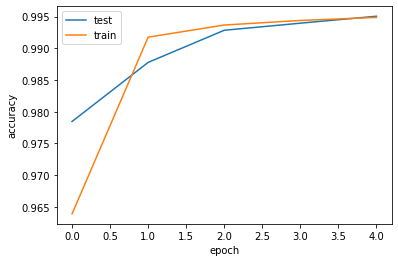

In [20]:
plt.plot(history.history['val_accuracy'], label='test')
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [21]:
unet_50.evaluate(keras_generator(val_df, batch_size, preprocess_input), steps=25)

25/25 [==============================] - 12s 489ms/step - loss: 0.0125 - accuracy: 0.9951


[0.012523048557341099, 0.9950670003890991]

-123.68 151.061


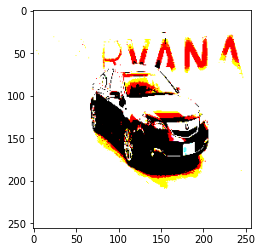

In [22]:
for X, y in keras_generator(val_df, 16, preprocess_input):
    plt.imshow(X[1])
    print(X[1].min(), X[1].max())
    break

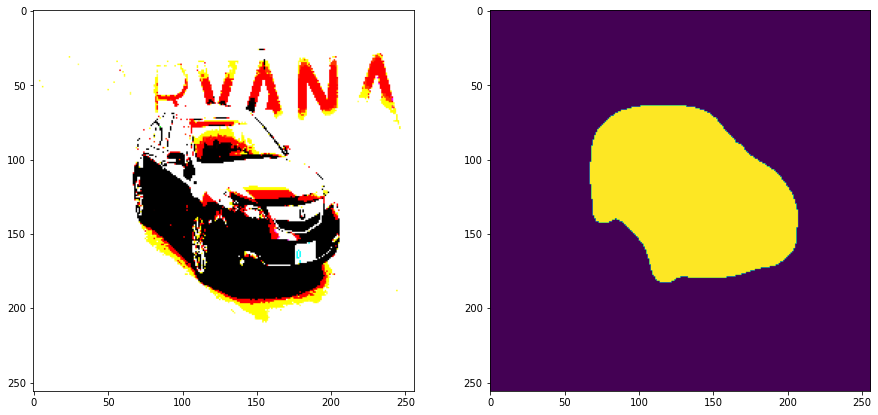

In [23]:
pred = unet_50.predict(X)
idx = 1
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(X[idx])
axes[1].imshow(pred[idx, ..., 0] > 0.5)

plt.show()

По метрикам и по визуализации получили, на мой взгляд, очень хороший результат. Добиться его помог подбор архитектуры сети и ее параметров.